In [1]:
import numpy as np
import keras
from keras.layers import *
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from q_lstm_tf_v2 import QLSTM, dtype_global
from matplotlib import pyplot as plt
from keras.models import load_model
tf.keras.backend.set_floatx('float64')
import os
import dev


Using Quantum Device: <lightning.qubit device (wires=7) at 0x26bf0671290>


# Check for GPU availibility

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
number_of_classes = 2

model = keras.Sequential([
    keras.layers.Input(shape=(124, 129)),
    Conv1D(filters=64, kernel_size=3, activation="gelu", padding="same"),
    MaxPooling1D(pool_size=2, strides=2, padding="same"),
    Conv1D(filters=48, kernel_size=3, activation="gelu", padding="same"),
    MaxPooling1D(pool_size=2, strides=2, padding="same"),
    Conv1D(filters=32, kernel_size=3, activation="gelu", padding="same"),
    MaxPooling1D(pool_size=2, strides=2, padding="same"),
    BatchNormalization(),
    QLSTM(128, return_sequences=True, wires=dev.qubits, layers=1),
    MaxPooling1D(pool_size=2, strides=2, padding="same"),
    Dropout(0.1),
    TimeDistributed(Dense(64,activation='gelu')),
    TimeDistributed(Dense(32,activation='gelu')),
    TimeDistributed(Dense(16,activation='gelu')),
    TimeDistributed(Dense(8,activation='gelu')),
    Flatten(),
    Dense(number_of_classes,activation='gelu')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 124, 64)           24832     
                                                                 
 max_pooling1d (MaxPooling1  (None, 62, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 31, 64)            0         
 g1D)                                                            
                                                                 
 qlstm (QLSTM)               (None, 31, 128)           0 (unused)
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 16, 128)           0

In [4]:
train_spectrogram_ds = tf.data.experimental.load(
    'data/tf/train.ds', element_spec=None, compression=None, reader_func=None
)

val_spectrogram_ds = tf.data.experimental.load(
    'data/tf/val.ds', element_spec=None, compression=None, reader_func=None
)

test_spectrogram_ds = tf.data.experimental.load(
    'data/tf/test.ds', element_spec=None, compression=None, reader_func=None
)

batch_size = 64

train_spectrogram_ds.map(lambda x, y: (tf.cast(x, dtype=dtype_global), y))
train_spectrogram_ds = train_spectrogram_ds.unbatch().filter(lambda x, y: y == 0 or y == 1).batch(batch_size)

val_spectrogram_ds.map(lambda x, y: (tf.cast(x, dtype=dtype_global), y))
val_spectrogram_ds = val_spectrogram_ds.unbatch().filter(lambda x, y: y == 0 or y == 1).batch(batch_size)

test_spectrogram_ds.map(lambda x, y: (tf.cast(x, dtype=dtype_global), y))
test_spectrogram_ds = test_spectrogram_ds.unbatch().filter(lambda x, y: y == 0 or y == 1).batch(batch_size)

train_spectrogram_ds = train_spectrogram_ds
val_spectrogram_ds = val_spectrogram_ds
test_spectrogram_ds = test_spectrogram_ds


checkpoint_filepath = f"quantum/checkpoints/asr/qlstm/checkpoint.model.{QLSTM.__module__}.q{dev.qubits}.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [5]:
if os.path.isfile(checkpoint_filepath) and False:
    model_loaded = load_model(checkpoint_filepath, custom_objects={'QLSTM': QLSTM})


In [6]:
train_spectrogram_ds = train_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [7]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.EarlyStopping(verbose=1, patience=2), model_checkpoint_callback],
)


Epoch 1/20
23/23 [==============================] - 1377s 60s/step - loss: 0.7309 - accuracy: 0.5126 - val_loss: 0.6928 - val_accuracy: 0.5135
Epoch 2/20
23/23 [==============================] - 1374s 60s/step - loss: 0.6945 - accuracy: 0.4986 - val_loss: 0.6929 - val_accuracy: 0.5135
Epoch 3/20
23/23 [==============================] - 1377s 60s/step - loss: 0.7600 - accuracy: 0.4790 - val_loss: 0.6932 - val_accuracy: 0.4865
Epoch 3: early stopping


Text(0, 0.5, 'Accuracy [%]')

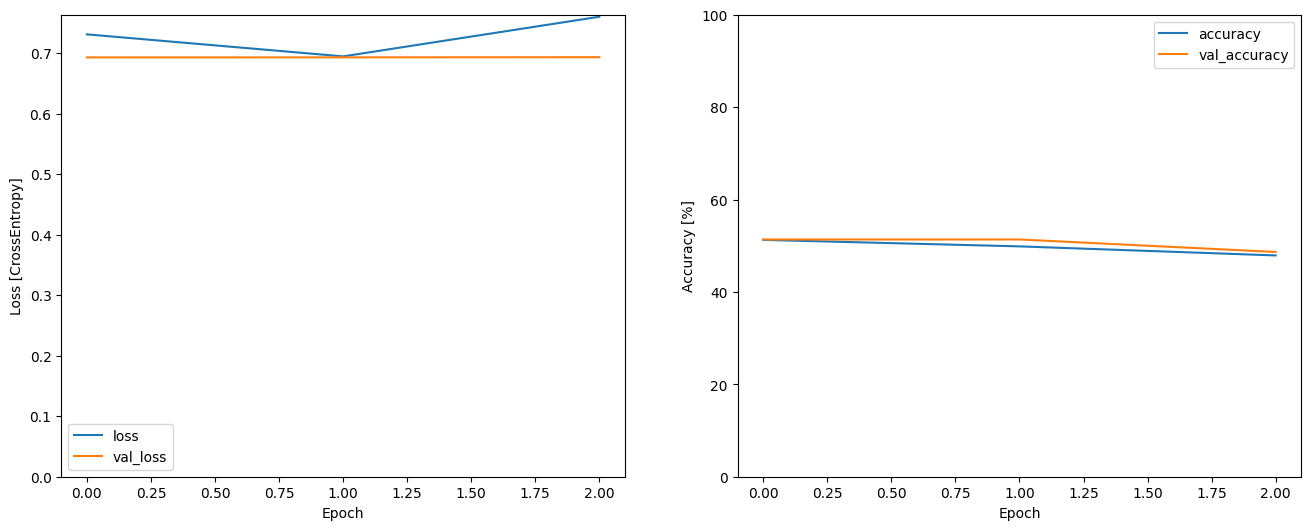

In [8]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [9]:
model.evaluate(test_spectrogram_ds, return_dict=True)

5/5 [==============================] - 108s 21s/step - loss: 0.6931 - accuracy: 0.5144


{'loss': 0.693134691407462, 'accuracy': 0.5143884892086331}